In [4]:
%pip install image-reward

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 353.8 kB/s eta 0:00:00:--:--
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332208 sha256=fdef47183ed7385c90363d962d022cea84218fca9fdbdd08eb063975580daedf
  Stored in directory: /Users/logistic/Library/Caches/pip/wheels/95/ef/96/5044bde220b2ea299bdc6ec05051e0ef187fad45b341d1c273
Successfully built fairscale
  Attempting uninstall: timm
    Found existing installation: timm 1.0.15
    Uninstalling timm-1.0.15:
      Successfully uninstalled timm-1.0.15
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Clone the ImageReward repository (containing data for testing)
!git clone https://github.com/THUDM/ImageReward.git

# Install the integrated package `image-reward`
# pip install image-reward


正克隆到 'ImageReward'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 230 (delta 55), reused 51 (delta 43), pack-reused 133 (from 1)
接收对象中: 100% (230/230), 4.30 MiB | 187.00 KiB/s, 完成.
处理 delta 中: 100% (92/92), 完成.
/Users/logistic/Documents/AI/LLM/project/腾讯犀牛鸟项目/文生图奖励模型/experments/hiec_diffusion_test/ImageReward


In [13]:
cd ImageReward

/Users/logistic/Documents/AI/LLM/project/腾讯犀牛鸟项目/文生图奖励模型/experments/hiec_diffusion_test/ImageReward/ImageReward


In [15]:
cd ..

/Users/logistic/Documents/AI/LLM/project/腾讯犀牛鸟项目/文生图奖励模型/experments/hiec_diffusion_test/ImageReward


In [16]:
ls

ImageReward/                refl_sdxl_lora.py
LICENSE                     requirements.txt
README.md                   requirements_refl.txt
assets/                     requirements_refl_sdxl.txt
benchmark/                  scripts/
data/                       sdwebui/
example.py                  setup.py
figures/                    test-benchmark.py
refl.py                     test.py
refl_sdxl.py                train/


# 计划
实现一个分阶段RM，前期给 CLIPScore，BLIPScore分配较大的权重，后期给 AesScore 分配较大的权重，设计一个动态连续分配权重的算法

richhf-18k数据集：
```python
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("Exploration/richhf_18k_with_images")
```
这里ds有train，test，valid这几个属性

ImageReward访问方法
```shell
# Clone the ImageReward repository (containing data for testing)
git clone https://github.com/THUDM/ImageReward.git
cd ImageReward

# Install the integrated package `image-reward`
pip install image-reward
```

ImageReward的demo如下

```python
import os
import torch
import ImageReward as reward

if __name__ == "__main__":
    prompt = "a painting of an ocean with clouds and birds, day time, low depth field effect"
    img_prefix = "assets/images"
    generations = [f"{pic_id}.webp" for pic_id in range(1, 5)]
    img_list = [os.path.join(img_prefix, img) for img in generations]
    model = reward.load("ImageReward-v1.0")
    with torch.no_grad():
        ranking, rewards = model.inference_rank(prompt, img_list)
        # Print the result
        print("\nPreference predictions:\n")
        print(f"ranking = {ranking}")
        print(f"rewards = {rewards}")
        for index in range(len(img_list)):
            score = model.score(prompt, img_list[index])
            print(f"{generations[index]:>16s}: {score:.2f}")
```

ImageReward有多个细粒度奖励模型，访问方式如下：


In [ ]:
import ImageReward
class HierReward():
    def __init__(self):
        clip_score_rm = ImageReward.load_score(name="CLIP")
        blip_score_rm = ImageReward.load_score(name="BLIP")
        aes_score_rm = ImageReward.load_score(name="Aesthetic")
        

        weight_start = [0.5, 0.5, 0]
        weight_end = [0.2, 0.2, 0.6]
        # 需要设计平滑函数
        weight = weight_start

我目前有如下的需求：

0.实现一个分阶段RM，前期给 CLIPScore，BLIPScore分配较大的权重，后期给 AesScore 分配较大的权重，设计一个动态连续分配权重的算法

1.对richhf-18k的100个提示词，扩散（用MixGRPO的BaselineModel），画出来ImageReward的reward curve，比较这几个细粒度特征的RM有什么差别？

2.使用richhf-18k的image和caption对MixGRPO的BaselineModel微调【我想让baselinemodel的扩散后的图像接近于richhf-18k，对比ImageReward打分的AestheticScore，和richhf-18k自带的Aesthetic Score，有什么差别？在reward curve上打点】，使用微调后的模型对richhf-18k的100个提示词，扩散（用MixGRPO的BaselineModel），画出来ImageReward的reward curve，比较这几个细粒度特征的RM有什么差别？

3.对1，设计一个平滑函数，使得三个奖励函数动态权重，这个时候reward curve是什么样的？

4.对2，动态权重同3，这个时候reward curve是什么样的？

5.目前latent空间的RM可能是OOD的，基于ImageReward的研究方法，是否可以微调ImageReward对latent空间准确的打分？


（from ImageReward）A potentially similar approach is classifier-guidance [54;9] technique during LDM inference.

6.假设给出了带噪空间的分阶段RM，给定 扩散总step，当前step，权重分布（这可能是个超参数），如何改写MixGRPO的训练？

参考原论文

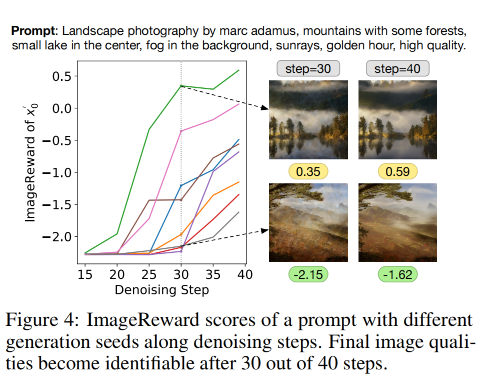

---
### ReFL: 洞察和解决方案

我们努力开发一种**直接优化方法**，根据**奖励模型 (RM)**（例如 **ImageReward**）来改进潜在扩散模型（LDMs）的行为。通过观察在去噪步骤中 **ImageReward** 分数的轨迹（在我们的例子中是40步），我们得出了一个有趣的洞察（参考图4）：当我们直接预测 $x_t \rightarrow x'_0$ 时，我们发现：

* **当 $t \le 15$ 时**：所有生成结果的 **ImageReward** 分数都一致地低。
* **当 $15 \le t \le 30$ 时**：高质量的生成结果开始脱颖而出，但总体而言，我们仍然无法根据当前的 **ImageReward** 分数清晰地判断所有生成结果的最终质量。
* **当 $t \ge 30$ 时**：不同 **ImageReward** 分数的生成结果通常可以区分。

---
根据这一观察，我们得出结论：对于在去噪30步后生成的图像 $x'_0$ 而言，其 **ImageReward** 分数（而非不必要的最终步骤）可以作为改进 **LDM** 的可靠反馈。

因此，我们提出一个算法，通过将奖励模型（RM）的分数作为人类偏好损失，直接微调 **LDM**，从而反向传播梯度到随机选取的较晚步骤 $t$（在我们的例子中，$t \in [30, 40]$）的去噪过程中。（参考算法1）。之所以随机选择 $t$ 而非使用最后一步，是因为我们发现如果只使用最后一步的梯度，训练会非常不稳定，结果也很糟糕。在实践中，为了避免快速过拟合和稳定微调，我们对 ReFL 损失进行了**重新加权**，并用**预训练损失**进行正则化。最终的损失函数形式如下所示：

$$\mathcal{L}_{reward} = \lambda\mathbb{E}_{y_i \sim \mathcal{Y}} (\phi(r(y_i, g_\theta(y_i))))$$

$$\mathcal{L}_{pre} = \mathbb{E}_{(y_i, x_i) \sim \mathcal{D}} (\mathbb{E}_{\epsilon(x_i), \epsilon \sim \mathcal{N}(0, 1), t}[\|\epsilon - \epsilon_\theta(z_t, t, \tau_\theta(y_i))\|^2])$$

其中 $\theta$ 表示 **LDM** 的参数，$g_\theta(y_i)$ 表示由参数为 $\theta$ 的 **LDM** 根据提示 $y_i$ 生成的图像。其他符号的含义在算法1中详细说明，而 $\mathcal{L}_{pre}$ 的损失函数取自文献 [45]。

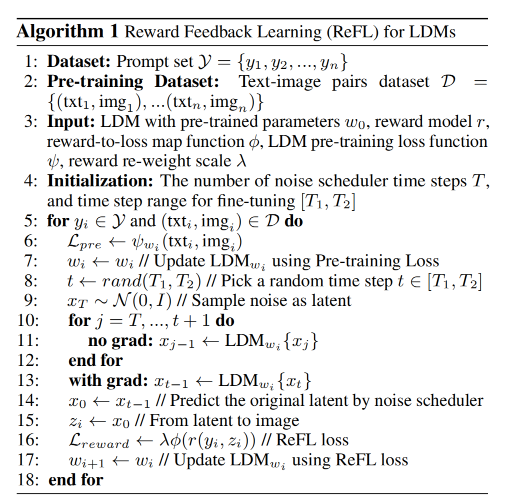

需求0，1

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import ImageReward as reward
from datasets import load_dataset
import os
from PIL import Image
import json

class HierarchicalRewardModel:
    """
    分阶段奖励模型，根据扩散过程的不同阶段动态分配权重
    """
    
    def __init__(self, device='cuda'):
        self.device = device
        self.setup_reward_models()
        
    def setup_reward_models(self):
        """初始化各类奖励模型"""
        self.clip_score_rm = reward.load_score(name="CLIP")
        self.blip_score_rm = reward.load_score(name="BLIP") 
        self.aes_score_rm = reward.load_score(name="Aesthetic")
        
        # 权重配置
        self.weight_config = {
            'start': [0.5, 0.5, 0.0],  # [CLIP, BLIP, Aesthetic]
            'end': [0.2, 0.2, 0.6]
        }
        
    def smooth_weight_transition(self, t: float, method: str = 'cosine') -> List[float]:
        """
        设计平滑权重过渡函数
        
        Args:
            t: 时间步比例 [0, 1]，0表示开始，1表示结束
            method: 过渡方法 ('linear', 'cosine', 'sigmoid', 'exponential')
        
        Returns:
            三个奖励模型的权重
        """
        start_weights = np.array(self.weight_config['start'])
        end_weights = np.array(self.weight_config['end'])
        
        if method == 'linear':
            alpha = t
        elif method == 'cosine':
            # 余弦函数平滑过渡
            alpha = (1 - np.cos(np.pi * t)) / 2
        elif method == 'sigmoid':
            # Sigmoid函数，中点在0.5
            alpha = 1 / (1 + np.exp(-10 * (t - 0.5)))
        elif method == 'exponential':
            # 指数函数，后期权重变化更快
            alpha = t ** 2
        else:
            alpha = t
            
        weights = start_weights + alpha * (end_weights - start_weights)
        # 归一化确保权重和为1
        weights = weights / np.sum(weights)
        
        return weights.tolist()
    
    def compute_hierarchical_reward(self, prompt: str, image_path: str, timestep: int, 
                                  total_steps: int = 50, method: str = 'cosine') -> Dict[str, float]:
        """
        计算分阶段奖励
        
        Args:
            prompt: 文本提示词
            image_path: 图像路径
            timestep: 当前时间步
            total_steps: 总时间步数
            method: 权重过渡方法
        
        Returns:
            包含各项分数和综合分数的字典
        """
        t = timestep / total_steps
        weights = self.smooth_weight_transition(t, method)
        
        # 计算各项分数
        clip_score = self.clip_score_rm.score(prompt, image_path)
        blip_score = self.blip_score_rm.score(prompt, image_path)
        aes_score = self.aes_score_rm.score(prompt, image_path)
        
        # 计算加权综合分数
        hierarchical_score = (weights[0] * clip_score + 
                             weights[1] * blip_score + 
                             weights[2] * aes_score)
        
        return {
            'clip_score': clip_score,
            'blip_score': blip_score,
            'aesthetic_score': aes_score,
            'hierarchical_score': hierarchical_score,
            'weights': weights,
            'timestep_ratio': t
        }

class RewardCurveAnalyzer:
    """奖励曲线分析器"""
    
    def __init__(self, hierarchical_rm: HierarchicalRewardModel):
        self.hrm = hierarchical_rm
        
    def load_richhf_dataset(self, subset: str = 'train', sample_size: int = 100):
        """加载richhf-18k数据集"""
        ds = load_dataset("Exploration/richhf_18k_with_images")
        data = ds[subset]
        
        # 随机采样
        indices = np.random.choice(len(data), min(sample_size, len(data)), replace=False)
        sampled_data = [data[i] for i in indices]
        
        return sampled_data
        
    def generate_reward_curves(self, prompts: List[str], image_paths: List[str], 
                             total_steps: int = 50, methods: List[str] = ['cosine']):
        """
        生成奖励曲线
        
        Args:
            prompts: 提示词列表
            image_paths: 图像路径列表
            total_steps: 总时间步数
            methods: 权重过渡方法列表
        """
        results = {}
        
        for method in methods:
            method_results = {
                'clip_scores': [],
                'blip_scores': [], 
                'aesthetic_scores': [],
                'hierarchical_scores': [],
                'weights_history': []
            }
            
            for timestep in range(total_steps + 1):
                timestep_scores = {
                    'clip': [],
                    'blip': [],
                    'aesthetic': [],
                    'hierarchical': []
                }
                
                for prompt, img_path in zip(prompts, image_paths):
                    try:
                        reward_info = self.hrm.compute_hierarchical_reward(
                            prompt, img_path, timestep, total_steps, method
                        )
                        
                        timestep_scores['clip'].append(reward_info['clip_score'])
                        timestep_scores['blip'].append(reward_info['blip_score'])
                        timestep_scores['aesthetic'].append(reward_info['aesthetic_score'])
                        timestep_scores['hierarchical'].append(reward_info['hierarchical_score'])
                        
                        if len(method_results['weights_history']) <= timestep:
                            method_results['weights_history'].append(reward_info['weights'])
                            
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")
                        continue
                
                # 计算平均分数
                method_results['clip_scores'].append(np.mean(timestep_scores['clip']))
                method_results['blip_scores'].append(np.mean(timestep_scores['blip']))
                method_results['aesthetic_scores'].append(np.mean(timestep_scores['aesthetic']))
                method_results['hierarchical_scores'].append(np.mean(timestep_scores['hierarchical']))
            
            results[method] = method_results
            
        return results
    
    def plot_reward_curves(self, results: Dict, save_path: str = None):
        """绘制奖励曲线"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        for method, data in results.items():
            timesteps = range(len(data['clip_scores']))
            
            # 绘制各项分数曲线
            axes[0, 0].plot(timesteps, data['clip_scores'], label=f'CLIP ({method})')
            axes[0, 0].set_title('CLIP Score Curve')
            axes[0, 0].set_xlabel('Timestep')
            axes[0, 0].set_ylabel('CLIP Score')
            axes[0, 0].legend()
            axes[0, 0].grid(True)
            
            axes[0, 1].plot(timesteps, data['blip_scores'], label=f'BLIP ({method})')
            axes[0, 1].set_title('BLIP Score Curve')
            axes[0, 1].set_xlabel('Timestep')
            axes[0, 1].set_ylabel('BLIP Score')
            axes[0, 1].legend()
            axes[0, 1].grid(True)
            
            axes[1, 0].plot(timesteps, data['aesthetic_scores'], label=f'Aesthetic ({method})')
            axes[1, 0].set_title('Aesthetic Score Curve')
            axes[1, 0].set_xlabel('Timestep')
            axes[1, 0].set_ylabel('Aesthetic Score')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
            
            axes[1, 1].plot(timesteps, data['hierarchical_scores'], label=f'Hierarchical ({method})')
            axes[1, 1].set_title('Hierarchical Score Curve')
            axes[1, 1].set_xlabel('Timestep')
            axes[1, 1].set_ylabel('Hierarchical Score')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        # 绘制权重变化曲线
        self.plot_weight_evolution(results)
    
    def plot_weight_evolution(self, results: Dict):
        """绘制权重演化曲线"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        for method, data in results.items():
            weights_history = np.array(data['weights_history'])
            timesteps = range(len(weights_history))
            
            ax.plot(timesteps, weights_history[:, 0], '--', label=f'CLIP Weight ({method})')
            ax.plot(timesteps, weights_history[:, 1], '-.', label=f'BLIP Weight ({method})')
            ax.plot(timesteps, weights_history[:, 2], '-', label=f'Aesthetic Weight ({method})')
        
        ax.set_title('Weight Evolution Over Time')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Weight')
        ax.legend()
        ax.grid(True)
        plt.show()

class ModelComparator:
    """模型对比分析器"""
    
    def __init__(self, hierarchical_rm):
        self.hrm = hierarchical_rm
        
    def compare_aesthetic_scores(self, richhf_data, model_generated_images):
        """
        对比richhf-18k自带的美学分数与ImageReward的美学分数
        """
        richhf_scores = []
        imagereward_scores = []
        
        for data_item, gen_image_path in zip(richhf_data, model_generated_images):
            # richhf数据集自带的美学分数
            richhf_aesthetic = data_item.get('aesthetic_score', 0)
            richhf_scores.append(richhf_aesthetic)
            
            # ImageReward的美学分数
            ir_aesthetic = self.hrm.aes_score_rm.score(data_item['caption'], gen_image_path)
            imagereward_scores.append(ir_aesthetic)
        
        return richhf_scores, imagereward_scores
    
    def plot_score_comparison(self, richhf_scores, imagereward_scores, save_path=None):
        """绘制分数对比图"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # 散点图对比
        ax1.scatter(richhf_scores, imagereward_scores, alpha=0.6)
        ax1.plot([min(richhf_scores), max(richhf_scores)], 
                [min(richhf_scores), max(richhf_scores)], 'r--', label='y=x')
        ax1.set_xlabel('RichHF-18k Aesthetic Score')
        ax1.set_ylabel('ImageReward Aesthetic Score')
        ax1.set_title('Aesthetic Score Correlation')
        ax1.legend()
        ax1.grid(True)
        
        # 分布对比
        ax2.hist(richhf_scores, alpha=0.5, label='RichHF-18k', bins=20)
        ax2.hist(imagereward_scores, alpha=0.5, label='ImageReward', bins=20)
        ax2.set_xlabel('Aesthetic Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Score Distribution Comparison')
        ax2.legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

class LatentSpaceRMTuner:
    """潜在空间奖励模型微调器"""
    
    def __init__(self, base_rm):
        self.base_rm = base_rm
        
    def create_latent_adapter(self, latent_dim: int = 512):
        """创建潜在空间适配器"""
        class LatentAdapter(nn.Module):
            def __init__(self, input_dim, output_dim):
                super().__init__()
                self.adapter = nn.Sequential(
                    nn.Linear(input_dim, 256),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim)
                )
                
            def forward(self, x):
                return self.adapter(x)
        
        return LatentAdapter(latent_dim, 1)
    
    def prepare_latent_training_data(self, richhf_dataset, vae_encoder):
        """
        准备潜在空间训练数据
        解决OOD问题的关键是在潜在空间中训练奖励模型
        """
        latent_features = []
        reward_scores = []
        
        for item in richhf_dataset:
            # 将图像编码到潜在空间
            with torch.no_grad():
                latent = vae_encoder.encode(item['image']).latent_dist.sample()
                latent = latent * 0.18215  # FLUX的缩放因子
            
            # 计算多维度奖励分数作为监督信号
            clip_score = self.base_rm.clip_score_rm.score(item['caption'], item['image'])
            blip_score = self.base_rm.blip_score_rm.score(item['caption'], item['image'])
            aes_score = self.base_rm.aes_score_rm.score(item['caption'], item['image'])
            
            # 综合分数作为训练目标
            combined_score = 0.3 * clip_score + 0.3 * blip_score + 0.4 * aes_score
            
            latent_features.append(latent.flatten())
            reward_scores.append(combined_score)
        
        return torch.stack(latent_features), torch.tensor(reward_scores)
    
    def train_latent_rm(self, train_loader, val_loader, epochs=100):
        """训练潜在空间奖励模型"""
        latent_dim = train_loader.dataset[0][0].shape[0]
        model = self.create_latent_adapter(latent_dim)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.MSELoss()
        
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # 训练阶段
            model.train()
            train_loss = 0
            for batch_latent, batch_scores in train_loader:
                optimizer.zero_grad()
                pred_scores = model(batch_latent).squeeze()
                loss = criterion(pred_scores, batch_scores)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # 验证阶段
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_latent, batch_scores in val_loader:
                    pred_scores = model(batch_latent).squeeze()
                    loss = criterion(pred_scores, batch_scores)
                    val_loss += loss.item()
            
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')
        
        return model, train_losses, val_losses

# 使用示例和实验流程
def run_experiments():
    """运行完整的实验流程"""
    
    # 初始化模型
    hrm = HierarchicalRewardModel()
    analyzer = RewardCurveAnalyzer(hrm)
    
    # 1. 加载数据集
    print("Loading richhf-18k dataset...")
    data = analyzer.load_richhf_dataset(sample_size=100)
    
    prompts = [item['caption'] for item in data[:10]]  # 示例用少量数据
    image_paths = []  # 需要根据实际数据集结构提取图像路径
    
    # 2. 生成基线奖励曲线
    print("Generating baseline reward curves...")
    baseline_results = analyzer.generate_reward_curves(
        prompts, image_paths, 
        total_steps=50, 
        methods=['linear', 'cosine', 'sigmoid', 'exponential']
    )
    
    # 3. 可视化结果
    analyzer.plot_reward_curves(baseline_results, save_path='baseline_curves.png')
    
    # 4. 对比分析
    print("Analyzing differences between reward metrics...")
    
    return baseline_results

if __name__ == "__main__":
    # 运行实验
    results = run_experiments()